Let say we want to say something about following problem:

$$
y' = Ay, y(0)=1 , A = \text{Uniform}(0,1) 
$$

The solution of this problem is a family of random variables $y(t)= e^{tA}$ the brain dead way to obtain this numerically is sampling $A$ and solving a differential equation multiple times. <br>

 But instead wanting simulations of $y(t)$ we find it easier to make a Monte Carlo techniques that calculate things of the following form $E[f(y(t))]$ where $f$ analytic which we call weak solutions. Great examples are $E[y(t)]$ and $E[y^{2}(t)]$ which contain some information about $y(t)$. <br>

How is actually very simple:
$$
\begin{align*}
E_y[f(y(t))] &= E_y[E_A[f(y(t)) \mid  A]] \\    
           &= E_y[E_A[f(y(t,A))]] \\    
            &= E_y[E_A[f(E_Y[Y(t,A)])]] \\
\end{align*}
$$
$y(t,A)$ is the solution of the ODE given $A$ and $Y$ an unbiased estimator of it.
We already explained how to deal with $f$, see period1 analytic functions. (this is problematic notation ...) <br> 

Ofcourse if $f$ isn't nice you can settle for approximations with analytical functions. <br>

Note that it is possible to calculate the characteristic function for $y(t)$ (https://en.wikipedia.org/wiki/Characteristic_function) or weak solutions can approximate strong solutions. We will later discuss a good way to do this.<br>

Let's implement this into a code example the from the analytic solution we can easily obtain:

$$
\begin{align*}
E_A[y(t)] &=  \frac{e^{t}}{t} - \frac{1}{t} \\ 
E_A[y^{2}(t)] &=  \frac{e^{2t}}{2t} - \frac{1}{2t}  
\end{align*}
$$

In [152]:
from random import random
from math import exp,sqrt

#estimator for y(t,a)
def Ya(t,a):
    return (1+a*Ya(random()*t,a) if random()<t else 1) if t<1 else 1+t*a*Ya(random()*t,a)

# estimator for y(t)
def Y(t):
    return Ya(t,random())
    
# estimator for y(t)**2
def Y2(t):
    A = random()
    return Ya(t,A)*Ya(t,A) 

sol = 0
sol2 = 0
nsim = 10**4
t = 3 # 0<t

for _ in range(nsim):
    sol += Y(t)/nsim
    sol2 += Y2(t)/nsim

s =  exp(t)/t -1/t #analytic solution
percentage_error = (sol - s)/s

s2 =  exp(2*t)/(2*t) -1/(2*t) #analytic solution
percentage_error2 = (sol2 - s2)/s2

print(f"sol({t}) is approx = {sol}")
print(f"%error = {percentage_error}")

print(f"sol2({t}) is approx = {sol2}")
print(f"%error2 = {percentage_error2}")

sd = sqrt(sol2-sol**2)
print(f"standard deviation of y(3) is approx (biased) {sd}")

sol(3) is approx = 6.231020735713968
%error = -0.020563986102425803
sol2(3) is approx = 62.61344686180105
%error2 = -0.06646669610734911
standard deviation of y(3) is approx (biased) 4.877276643056411


Now let's make a unbiased estimator for the density function for $y(1)$ through the inversion formula:

$$
\begin{align*}
f(x)&= \frac{1}{2 \pi} \int_{-\infty}^{\infty} e^{-i t x} \varphi(t) dt \\
    & \approx \frac{1}{2 \pi} \int_{-1}^{1} e^{-i t x} \varphi(t) dt \\
    &=\frac{1}{\pi} E_T[e^{-i T x} \varphi(T)]
\end{align*}
$$
We did an approximation so we can use $T = \text{Uniform}(-1,1)$ for easy simulations but this isn't necessary. Now we can use the expression for the characteristic function that we got before. 

$$
f_{y(1)}(x) \approx \frac{1}{\pi} E_T[e^{-i T x} E_y[E_A[e^{iTE_Y[Y(1,A)]} ]]]
$$

With this expression we can make an unbiased (biased because of non necessary lazy approx) pointwise estimator of the density function of the solution. (we already have a technique in mind to use this to get an unbiased estimator of the coefficients of an orthonormal decomposition of the density function of the solution) <br>

To implement this we will be using Russian Roulette and maybe control variates because we aren't sure about the variance ...

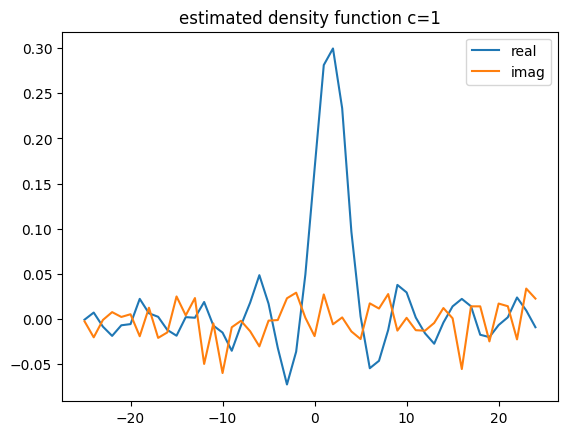

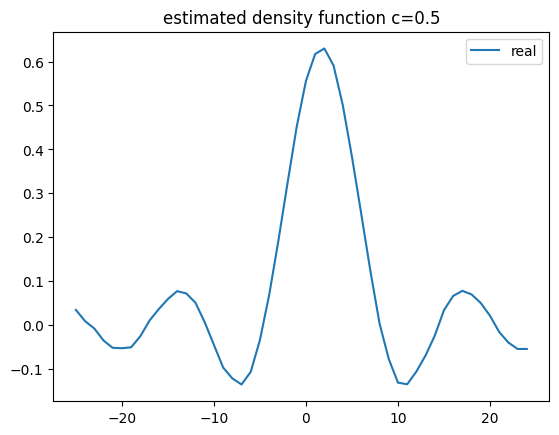

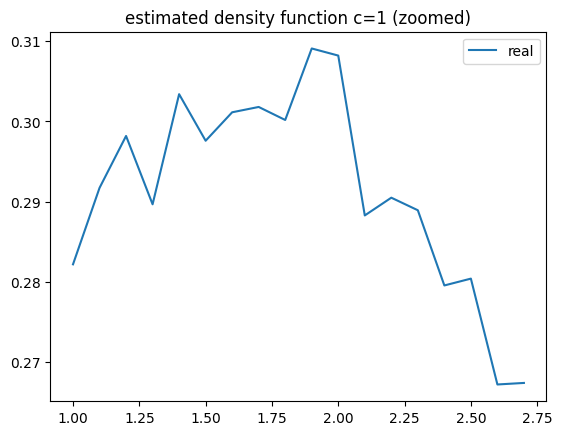

In [242]:
from random import random
import cmath
import numpy as np
import matplotlib.pyplot as plt


# this is the code out of period1 
#--------------------------------------
def amount_bernoulli(i):
    return amount_bernoulli(i+1) if random()*i<1 else i-1

def res(n,estimator):
    return 1 + estimator()*res(n-1,estimator) if n != 0 else 1    

def expE(estimator): #branching order 2
    return res(amount_bernoulli(0),estimator)
#-------------------------------------    
def Ya(t,a):
    return (1+a*Ya(random()*t,a) if random()<t else 1) if t<1 else 1+t*a*Ya(random()*t,a)

def iTEYa(T,a):
    return complex(0,1)*T*Ya(1,a)

# c parametrizes the lazy approx that we make
def ff(x,c):
    T = (random()*2-1)*c
    a = random()
    def estimator():
        return iTEYa(T,a)
    return cmath.exp(-complex(0,1)*T*x) * expE(estimator)/(cmath.pi*c)


def f(x,nsim=10**4,c=1):
    sol = 0
    for _ in range(nsim):
        sol += ff(x,c)/nsim
    return sol

xx = np.arange(-25,25,1)
yy = [f(x,10**4).real for x in xx]
zz = [f(x,10**3).imag for x in xx]

plt.plot(xx, yy,label ="real")
plt.plot(xx, zz, label ="imag")
plt.title("estimated density function c=1")
plt.legend()
plt.show()

    
xx = np.arange(-25,25,1)
yy = [f(x,nsim = 10**4,c=0.5).real for x in xx]

plt.plot(xx, yy,label ="real")
plt.title("estimated density function c=0.5")
plt.legend()
plt.show()

xx = np.arange(1,2.72,0.1)
yy = [f(x,10**4).real for x in xx]

plt.plot(xx, yy,label ="real")
plt.title("estimated density function c=1 (zoomed)")
plt.legend()
plt.show()

We are not sure what is happening here maybe bad properties because $f(x)$ is discontinuous , let's simulate the exact solution:

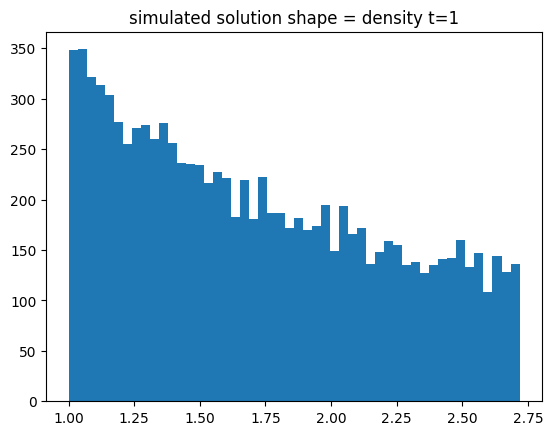

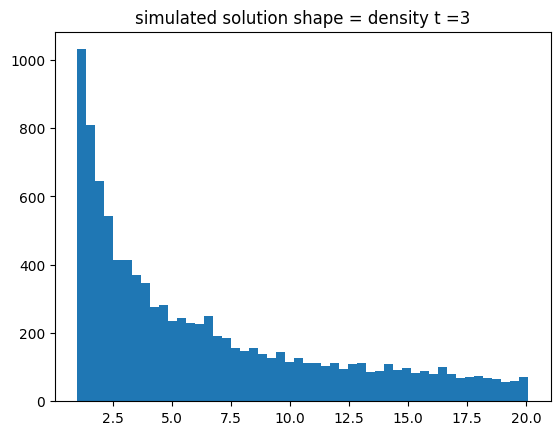

In [244]:
from random import random
import matplotlib.pyplot as plt
from math import exp

tmp = []
for _ in range(10**4):
    tmp.append(exp(random()))
    
plt.hist(tmp,bins=50)
plt.title("simulated solution shape = density t=1")
plt.show()

tmp = []
for _ in range(10**4):
    tmp.append(exp(3*random()))
    
plt.hist(tmp,bins=50)
plt.title("simulated solution shape = density t =3")
plt.show()
